In [2]:
# 导入相关包
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd import Variable

import transforms as transforms
from skimage import io
from skimage.transform import resize
from models import *
import cv2

In [3]:
# 加载模型
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

net = VGG('VGG19')
checkpoint = torch.load(os.path.join('checkpoint/', 'PrivateTest_model.t7'))
net.load_state_dict(checkpoint['net'])
net.cuda()
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
transform_test = transforms.Compose([
    transforms.TenCrop(44),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])


In [5]:
def predictExpression(image_file):
    
    raw_img = io.imread(image_file)
    gray = np.dot(raw_img[...,:3], [0.299, 0.587, 0.114])
    gray = resize(gray, (48,48), mode='symmetric').astype(np.uint8)
    img = gray[:, :, np.newaxis]

    img = np.concatenate((img, img, img), axis=2)
    img = Image.fromarray(img)
    inputs = transform_test(img)

    ncrops, c, h, w = np.shape(inputs)

    inputs = inputs.view(-1, c, h, w)
    inputs = inputs.cuda()

    outputs = net(inputs)

    outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops
    _, predicted = torch.max(outputs_avg.data, 0)
    
    label_id = int(predicted.cpu().numpy())
    
    score = F.softmax(outputs_avg,dim=0)
    
    score = score[label_id].cpu().item()
    
    
    label = class_names[label_id]
    
    return label,score,raw_img


In [6]:
label,score,raw_img = predictExpression('./images/fake1.png')

D:\Anaconda\envs\stylegan\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(-0.5, 1023.5, 1023.5, -0.5)

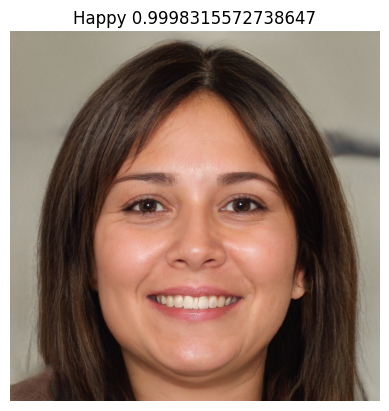

In [7]:
plt.imshow(raw_img)
plt.title(label + ' ' + str(score))
plt.axis('off')

In [8]:
label,score,raw_img = predictExpression('./images/sad.jpg')

(-0.5, 224.5, 223.5, -0.5)

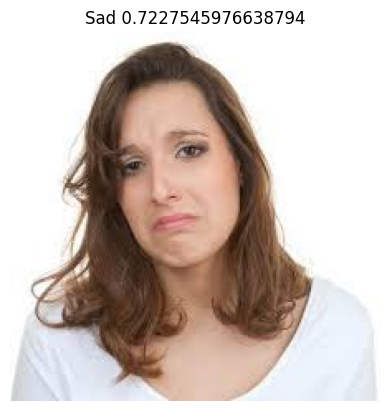

In [9]:
plt.imshow(raw_img)
plt.title(label + ' ' + str(score))
plt.axis('off')